In [106]:
import pandas as pd
import numpy as np
import random
import math
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 100
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from numpy.random import randn
np.random.seed(0)
import pickle
import gzip
from sklearn.preprocessing import MinMaxScaler
from sklearn import decomposition
from sklearn.preprocessing import scale
from sklearn.metrics import mean_squared_error
from geopy.distance import great_circle
from tqdm import tqdm

import torch

import time
from scipy.stats import norm
from sympy import Symbol, symbols, Matrix, sin, cos
from sympy import init_printing
from sympy.utilities.codegen import codegen
init_printing(use_latex=True)

In [4]:
# data loading

data_ver = '3'

# NOISE
with gzip.open(f'../data/segment_with_noise_v{data_ver}/ll_seg_500_noise_v{data_ver}.pkl.gzip', 'rb') as f:
    ll_seg_noise = pickle.load(f)
with gzip.open(f'../data/segment_with_noise_v{data_ver}/rl_seg_500_noise_v{data_ver}.pkl.gzip', 'rb') as f:
    rl_seg_noise = pickle.load(f)

# GROUND TRUTH
with gzip.open(f'../data/segment_groud_truth_v2/rl_seg_gt_500_v2.pkl.gzip', 'rb') as f:
    ll_seg_gps_gt = pickle.load(f)
with gzip.open(f'../data/segment_groud_truth_v2/ll_seg_gt_500_v2.pkl.gzip', 'rb') as f:
    rl_seg_gps_gt = pickle.load(f)

print(len(ll_seg_noise))
print(ll_seg_noise[0].shape[0])
ll_seg_noise[0].head()

500
153


,y,x,Vy,Vx,theta,psi,phi,omega_Xv,omega_Yv,omega_Zv,alpha_Xv,alpha_Yv,lane,y_noise,x_noise
68268,274.111469,109.920335,0.00,5.87,152.640,0.634,1.101,0.47,0.36,0.60,0.237,-0.150,1,274.552482,109.713725
68293,272.808525,110.598795,-0.01,5.88,152.633,0.648,1.087,-0.81,1.00,-0.26,0.212,-0.143,1,272.908564,110.574182
68318,271.504469,111.278905,0.00,5.90,152.626,0.677,1.130,-0.01,-0.45,-0.20,0.320,-0.018,1,271.749154,111.113036
68343,270.195971,111.961492,-0.01,5.91,152.607,0.720,1.148,-1.15,-0.40,0.47,0.242,-0.473,1,270.756194,112.243151
68368,268.884140,112.646555,-0.01,5.93,152.600,0.716,1.147,0.52,-0.02,-0.34,0.054,-0.277,1,269.351030,112.376572


In [6]:
# sample_freq = 50 # 5hz
sample_freq = 25 # 10hz
dt = 0.01 * sample_freq
dt

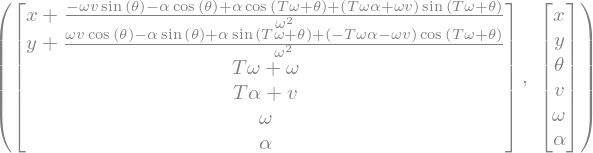

In [11]:
v, theta, omega, dts, x, y, lat, lon, alpha = symbols('v theta \omega T x y lat lon alpha')

# transition matrix
gs = Matrix([[x + (1 / omega**2) * ((v*omega + alpha * omega * dts) * sin(theta + omega * dts) + alpha * cos(theta + omega * dts) - v * omega * sin(theta) - alpha * cos(theta))],    
             [y + (1 / omega**2) * ((-v*omega - alpha * omega * dts) * cos(theta + omega * dts) + alpha * sin(theta + omega * dts) + v * omega * cos(theta) - alpha * sin(theta))],
             [omega + omega*dts],
             [alpha*dts + v],
             [omega],
             [alpha]])

# state vector             
state = Matrix([x, y, theta, v, omega, alpha])
gs, state

In [7]:
state

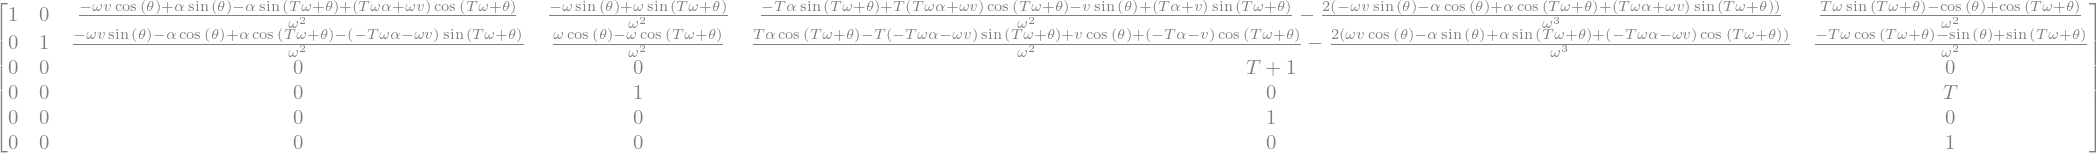

In [8]:
gs.jacobian(state)

## ekf_6states()

In [124]:
max_Vx = 6.5 # m/s
max_alpha_Vx = 2.193 # m/s2
max_omega_Zv = 1.56 # deg/s
max_omega_Zv_accel = 1 # deg/s2

s_gps = 0.5 * max_alpha_Vx * dt ** 2
s_yaw = 0.5 * max_omega_Zv * dt
s_vel = max_alpha_Vx * dt
s_omega = max_omega_Zv_accel * dt
s_accel = 0.05

sig_gps = 0.25
sig_theta = 0 * dt
sig_vel = 0 * dt
sig_omega = 1 * dt
sig_accel = 0

Q = np.diag([
    s_gps**2, s_gps**2, s_yaw**2, s_vel**2, s_omega**2, s_accel**2
])
Q

array([[0.00469653, 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.00469653, 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.038025  , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.30057806, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.0625    ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.0025    ]])

In [161]:
def ekf_6_stats(segment_df, Q=None):

    # constants definition
    max_Vx = 6.5 # m/s
    max_alpha_Vx = 2.193 # m/s2
    max_omega_Zv = 1.56 # deg/s
    max_omega_Zv_accel = 0.5 # 1 # deg/s2

    s_gps = 0.5 * max_alpha_Vx * dt ** 2
    s_yaw = 0.001 * dt # max_omega_Zv * dt
    s_vel = max_alpha_Vx * dt
    s_omega = max_omega_Zv_accel * dt
    s_accel = 0.25

    sig_gps = 0.25
    sig_theta = 0.1
    sig_vel = 0 * dt
    sig_omega = 0.01
    sig_accel = 0

    x_noise = segment_df['x_noise'].values
    y_noise = segment_df['y_noise'].values
    Vx = segment_df['Vx'].values
    alpha_Xv = segment_df['alpha_Xv'].values
    theta = segment_df['theta'].values/180.0*np.pi             # rad
    omega_Zv = segment_df['omega_Zv'].values/180.0*np.pi       # rad/s

    # set initial values
    x = np.matrix([
        x_noise[0], y_noise[0], theta[0], Vx[0], omega_Zv[0], alpha_Xv[0]
    ]).T

    observations = np.vstack((
        x_noise, y_noise, Vx, omega_Zv, alpha_Xv
    ))

    P = 1 * np.eye(len(state))
    
    if Q is None:
        Q = np.diag([
            s_gps**2, s_gps**2, s_yaw**2, s_vel**2, s_omega**2, s_accel**2
        ])

    """ Q = np.diag([
        s_gps**2, s_gps**2, 0.0002, s_vel**2, 0.0002, s_accel**2
    ]) """

    """ Q = np.array([
        [s_gps**2, 0, 0.0001, 0.0001, 0.0001, 0.0001],
        [0, s_gps**2, 0.0001, 0.0001, 0.0001, 0.0001],
        [0, 0, s_yaw**2, 0.0001, 0.0001, 0.0001],
        [0, 0, 0.0001, 0.0001, s_vel**2, 0.0001],
        [0, 0, 0.0001, 0.0001, s_omega**2, 0],
        [0, 0, 0.0001, 0.0001, 0, s_accel**2],
    ]) """

    # Measurement covariance R matrix
    R = np.diag(
        [sig_gps**2, sig_gps**2, sig_vel**2, sig_omega**2, sig_accel**2]
    )

    I = np.eye(len(state))

    # measurement function, H
    H = np.array([
        [1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
        [0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
        [0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
    ])

    m = observations.shape[1]
    nx = Q.shape[0]
    ny = R.shape[0]

    x_est = np.zeros((m, nx))      # prediction of state vector                                                       

    for filterstep in np.arange(m):
        
        
        # state transition
        x[0] = x[0] + (1 / x[4]**2) * ((x[3]*x[4] + x[5] * x[4] * dt) * \
            np.sin(x[2] + x[4]* dt) + x[5] * np.cos(x[2] + x[4] * dt) - x[3] *  \
            x[4] * np.sin(x[2]) - x[5] * np.cos(x[2]))
        x[1] = x[1] + (1 / x[4]**2) * ((-x[3]*x[4] - x[5] * x[4] * dt) * \
            np.cos(x[2] + x[4]* dt) + x[5] * np.sin(x[2] + x[4] * dt) + x[3] * \
            x[4] * np.cos(x[2]) - x[5] * np.sin(x[2]))
        x[2] = (x[2] + x[4] * dt + np.pi) % (2.0 * np.pi) + np.pi
        x[3] = x[3] + x[5] * dt 
        x[4] = x[4]
        x[5] = x[5]
        
        
        # Calculate the Jacobian of the Dynamic Matrix A
        a13 = ((-x[4]*x[3]*np.cos(x[2]) + x[5]*np.sin(x[2]) - x[5]*np.sin(dt*x[4] + x[2]) + \
            (dt*x[4]*x[5] + x[4]*x[3])*np.cos(dt*x[4] + x[2]))/x[4]**2).item(0)

        a14 = ((-x[4]*np.sin(x[2]) + x[4]*np.sin(dt*x[4] + x[2]))/x[4]**2).item(0)

        a15 = ((-dt*x[5]*np.sin(dt*x[4] + x[2]) + dt*(dt*x[4]*x[5] + x[4]*x[3])* \
            np.cos(dt*x[4] + x[2]) - x[3]*np.sin(x[2]) + (dt*x[5] + x[3])* \
            np.sin(dt*x[4] + x[2]))/x[4]**2 - 2*(-x[4]*x[3]*np.sin(x[2]) - x[5]* \
            np.cos(x[2]) + x[5]*np.cos(dt*x[4] + x[2]) + (dt*x[4]*x[5] + x[4]*x[3])* \
            np.sin(dt*x[4] + x[2]))/x[4]**3).item(0)

        a16 = ((dt*x[4]*np.sin(dt*x[4] + x[2]) - np.cos(x[2]) + np.cos(dt * x[4] + x[2]))/x[4]**2).item(0)

        a23 = ((-x[4] * x[3] * np.sin(x[2]) - x[5] * np.cos(x[2]) + x[5] * np.cos(dt * x[4] + x[2]) - \
            (-dt * x[4]*x[5] - x[4] * x[3]) * np.sin(dt * x[4] + x[2])) / x[4]**2).item(0)
        a24 = ((x[4] * np.cos(x[2]) - x[4]*np.cos(dt*x[4] + x[2]))/x[4]**2).item(0)
        a25 = ((dt * x[5]*np.cos(dt*x[4] + x[2]) - dt * (-dt*x[4]*x[5] - x[4] * x[3]) * \
            np.sin(dt * x[4] + x[2]) + x[3]*np.cos(x[2]) + (-dt*x[5] - x[3])*np.cos(dt*x[4] + x[2]))/ \
            x[4]**2 - 2*(x[4]*x[3]*np.cos(x[2]) - x[5] * np.sin(x[2]) + x[5] * np.sin(dt*x[4] + x[2]) + \
            (-dt * x[4] * x[5] - x[4] * x[3])*np.cos(dt*x[4] + x[2]))/x[4]**3).item(0)
        a26 =  ((-dt*x[4]*np.cos(dt*x[4] + x[2]) - np.sin(x[2]) + np.sin(dt*x[4] + x[2]))/x[4]**2).item(0)
            
        JA = np.matrix([[1.0, 0.0, a13, a14, a15, a16],
                        [0.0, 1.0, a23, a24, a25, a26],
                        [0.0, 0.0, 1.0, 0.0, dt, 0.0],
                        [0.0, 0.0, 0.0, 1.0, 0.0, dt],
                        [0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
                        [0.0, 0.0, 0.0, 0.0, 0.0, 1.0]])
        
        
        # Project the error covariance ahead
        P = JA * P * JA.T + Q
        
        # Measurement Update (Correction)
        # ===============================
        # Measurement Function
        hx = np.matrix([[float(x[0])],
                        [float(x[1])],
                        [float(x[3])],
                        [float(x[4])],
                        [float(x[5])]])        
        
        S = H * P * H.T + R
        K = (P * H.T) * np.linalg.inv(S)

        # Update the estimate via
        Z = observations[:, filterstep].reshape(H.shape[0],1)
        y = Z - (hx) # innovation or residual
        x = x + (K * y) # update estimated state

        # Update the error covariance
        P = (I - (K * H)) * P

        x_est[filterstep] = x.T

    return x_est, x_noise, y_noise, segment_df['x'].values, segment_df['y'].values

### sample estimation

In [159]:
sample_idx = 201
sample_traj = ll_seg_noise[sample_idx]
sample_traj.head()

,y,x,Vy,Vx,theta,psi,phi,omega_Xv,omega_Yv,omega_Zv,alpha_Xv,alpha_Yv,lane,y_noise,x_noise
22302,717.822536,1209.676767,-0.02,5.24,357.536,0.891,2.125,-1.02,-0.29,0.06,0.124,-0.397,1,717.876258,1209.933827
22327,719.128814,1209.618994,-0.01,5.23,357.499,0.923,2.112,-0.42,-0.06,0.06,0.076,-0.426,1,719.091238,1209.485545
22352,720.433981,1209.558746,-0.01,5.22,357.482,0.980,2.045,-0.38,0.43,-0.08,0.135,-0.345,1,720.023939,1209.522587
22377,721.736926,1209.498497,-0.02,5.22,357.453,1.023,1.993,-0.27,0.64,-0.11,0.243,-0.361,1,721.614922,1209.252199
22402,723.040982,1209.438248,-0.01,5.22,357.416,0.997,1.927,-0.27,0.27,-0.29,0.146,-0.349,1,723.069575,1209.427037


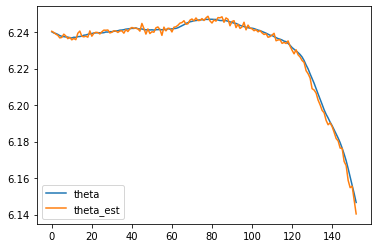

In [69]:
plt.plot(sample_traj['theta'].values/180.0*np.pi, label='theta')
plt.plot(
    (sample_traj['theta'].values/180.0*np.pi  + sample_traj['omega_Zv'].values/180.0*np.pi * dt + np.pi) % \
    (2 * np.pi) + np.pi, label='theta_est'
    )
plt.legend()

### scratch work

In [78]:
# P0 matrix
P = 5 * np.eye(len(state))
print(P, P.shape)
print()

max_Vx = 6.5 # m/s
max_alpha_Vx = 2.193 # m/s2
max_omega_Zv = 1.56 # deg/s
max_omega_Zv_accel = 1 # deg/s2

s_gps = 0.5 * max_alpha_Vx * dt ** 2
s_yaw = max_omega_Zv * dt
s_vel = max_Vx * dt
s_omega = 1.0 * dt
s_accel = max_alpha_Vx * 0.5

sig_gps = 2
sig_theta = 0*dt
sig_vel = 3*dt
sig_omega = 0*dt
sig_accel = 1
sig_yaw_rate = 0.1

# Process noise covariance Q matrix
# assume the processes are indepedent of each other
Q = np.diag([
    s_gps**2, s_gps**2, s_yaw**2, s_vel**2, s_omega**2, s_accel**2
])

print(Q, Q.shape)
print()

# Measurement covariance R matrix

R = np.diag(
    [sig_gps**2, sig_gps**2, sig_vel**2, sig_yaw_rate**2, sig_accel**2]
)
print(R, R.shape)

I = np.eye(len(state))

# measurement function, H

H = np.array([
    [1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
    [0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
])

[[5. 0. 0. 0. 0. 0.]
 [0. 5. 0. 0. 0. 0.]
 [0. 0. 5. 0. 0. 0.]
 [0. 0. 0. 5. 0. 0.]
 [0. 0. 0. 0. 5. 0.]
 [0. 0. 0. 0. 0. 5.]] (6, 6)

[[0.00469653 0.         0.         0.         0.         0.        ]
 [0.         0.00469653 0.         0.         0.         0.        ]
 [0.         0.         0.1521     0.         0.         0.        ]
 [0.         0.         0.         2.640625   0.         0.        ]
 [0.         0.         0.         0.         0.0625     0.        ]
 [0.         0.         0.         0.         0.         1.20231225]] (6, 6)

[[4.     0.     0.     0.     0.    ]
 [0.     4.     0.     0.     0.    ]
 [0.     0.     0.5625 0.     0.    ]
 [0.     0.     0.     0.01   0.    ]
 [0.     0.     0.     0.     1.    ]] (5, 5)


In [52]:
x_est_sample, x_noise, y_noise, x, y = ekf_6_stats(sample_traj)

In [79]:
# measurements

x_noise = sample_traj['x_noise'].values
y_noise = sample_traj['y_noise'].values
Vx = sample_traj['Vx'].values
alpha_Xv = sample_traj['alpha_Xv'].values
theta = sample_traj['theta'].values/180.0*np.pi             # rad
omega_Zv = sample_traj['omega_Zv'].values/180.0*np.pi       # rad/s

x = np.matrix([
    x_noise[0], y_noise[0], theta[0], Vx[0], np.average(omega_Zv), np.average(alpha_Xv)
]).T

observations = np.vstack((
    x_noise, y_noise, Vx, omega_Zv, alpha_Xv
))

m = observations.shape[1]
print(observations.shape[1])

# Preallocation for Plotting
x0 = []
x1 = []
x2 = []
x3 = []
x4 = []
x5 = []
Zx = []
Zy = []
Px = []
Py = []
Pdx= []
Pdy= []
Pddx=[]
Pddy=[]
Pdv =[]
Kx = []
Ky = []
Kdx= []
Kdy= []
Kddx=[]
Kdv= []
dstate=[]

153


In [81]:
for filterstep in range(m):

    # Time Update (Prediction)
    # ========================
    # Project the state ahead
    # see "Dynamic Matrix"
    
    # if np.abs(observations[2][filterstep]) < 0.0001: # Driving straight
    #     x[4] = 0.0001
    
    x[0] = x[0] + (1 / x[4]**2) * ((x[3]*x[4] + x[5] * x[4] * dt) * \
        np.sin(x[2] + x[4]* dt) + x[5] * np.cos(x[2] + x[4] * dt) - x[3] *  \
        x[4] * np.sin(x[2]) - x[5] * np.cos(x[2]))
    x[1] = x[1] + (1 / x[4]**2) * ((-x[3]*x[4] - x[5] * x[4] * dt) * \
        np.cos(x[2] + x[4]* dt) + x[5] * np.sin(x[2] + x[4] * dt) + x[3] * \
        x[4] * np.cos(x[2]) - x[5] * np.sin(x[2]))
    x[2] = (x[2] + x[4] * dt)#  + np.pi) % (2.0 * np.pi) - np.pi
    x[3] = x[3] + x[5] * dt 
    x[4] = x[4]
    x[5] = x[5]
    
    
    # Calculate the Jacobian of the Dynamic Matrix A
    # see "Calculate the Jacobian of the Dynamic Matrix with respect to the state vector"
    a13 = ((-x[4]*x[3]*np.cos(x[2]) + x[5]*np.sin(x[2]) - x[5]*np.sin(dt*x[4] + x[2]) + \
        (dt*x[4]*x[5] + x[4]*x[3])*np.cos(dt*x[4] + x[2]))/x[4]**2).item(0)

    a14 = ((-x[4]*np.sin(x[2]) + x[4]*np.sin(dt*x[4] + x[2]))/x[4]**2).item(0)

    a15 = ((-dt*x[5]*np.sin(dt*x[4] + x[2]) + dt*(dt*x[4]*x[5] + x[4]*x[3])* \
        np.cos(dt*x[4] + x[2]) - x[3]*np.sin(x[2]) + (dt*x[5] + x[3])* \
        np.sin(dt*x[4] + x[2]))/x[4]**2 - 2*(-x[4]*x[3]*np.sin(x[2]) - x[5]* \
        np.cos(x[2]) + x[5]*np.cos(dt*x[4] + x[2]) + (dt*x[4]*x[5] + x[4]*x[3])* \
        np.sin(dt*x[4] + x[2]))/x[4]**3).item(0)

    a16 = ((dt*x[4]*np.sin(dt*x[4] + x[2]) - np.cos(x[2]) + np.cos(dt * x[4] + x[2]))/x[4]**2).item(0)

    a23 = ((-x[4] * x[3] * np.sin(x[2]) - x[5] * np.cos(x[2]) + x[5] * np.cos(dt * x[4] + x[2]) - \
        (-dt * x[4]*x[5] - x[4] * x[3]) * np.sin(dt * x[4] + x[2])) / x[4]**2).item(0)
    a24 = ((x[4] * np.cos(x[2]) - x[4]*np.cos(dt*x[4] + x[2]))/x[4]**2).item(0)
    a25 = ((dt * x[5]*np.cos(dt*x[4] + x[2]) - dt * (-dt*x[4]*x[5] - x[4] * x[3]) * \
        np.sin(dt * x[4] + x[2]) + x[3]*np.cos(x[2]) + (-dt*x[5] - x[3])*np.cos(dt*x[4] + x[2]))/ \
        x[4]**2 - 2*(x[4]*x[3]*np.cos(x[2]) - x[5] * np.sin(x[2]) + x[5] * np.sin(dt*x[4] + x[2]) + \
        (-dt * x[4] * x[5] - x[4] * x[3])*np.cos(dt*x[4] + x[2]))/x[4]**3).item(0)
    a26 =  ((-dt*x[4]*np.cos(dt*x[4] + x[2]) - np.sin(x[2]) + np.sin(dt*x[4] + x[2]))/x[4]**2).item(0)
        
    JA = np.matrix([[1.0, 0.0, a13, a14, a15, a16],
                    [0.0, 1.0, a23, a24, a25, a26],
                    [0.0, 0.0, 1.0, 0.0, dt, 0.0],
                    [0.0, 0.0, 0.0, 1.0, 0.0, dt],
                    [0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
                    [0.0, 0.0, 0.0, 0.0, 0.0, 1.0]])
    
    
    # Project the error covariance ahead
    P = JA * P * JA.T + Q
    
    # Measurement Update (Correction)
    # ===============================
    # Measurement Function
    hx = np.matrix([[float(x[0])],
                    [float(x[1])],
                    [float(x[3])],
                    [float(x[4])],
                    [float(x[5])]])        
    
    S = H * P * H.T + R
    K = (P * H.T) * np.linalg.inv(S)

    # Update the estimate via
    Z = observations[:,filterstep].reshape(H.shape[0],1)
    y = Z - (hx)                         # Innovation or Residual
    x = x + (K * y)

    # Update the error covariance
    P = (I - (K * H)) * P


    # Save states for Plotting
    x0.append(float(x[0]))
    x1.append(float(x[1]))
    x2.append(float(x[2]))
    x3.append(float(x[3]))
    x4.append(float(x[4]))
    x5.append(float(x[5]))
    Zx.append(float(Z[0]))
    Zy.append(float(Z[1]))    
    Px.append(float(P[0,0]))
    Py.append(float(P[1,1]))
    Pdx.append(float(P[2,2]))
    Pdy.append(float(P[3,3]))
    Pddx.append(float(P[4,4]))
    Pdv.append(float(P[5,5]))
    Kx.append(float(K[0,0]))
    Ky.append(float(K[1,0]))
    Kdx.append(float(K[2,0]))
    Kdy.append(float(K[3,0]))
    Kddx.append(float(K[4,0]))
    Kdv.append(float(K[5,0]))

### sample plots

In [99]:
def plot_traj_comp(x_est, y_est, x_noise, y_noise, x, y, sample_idx):

    plt.figure(dpi=100, figsize=(7, 4))

    # EKF State
    plt.plot(x_est, y_est, label='ekf_6states prediction', c='green', lw=2)

    # ground truth
    plt.plot(x, y, label='ground truth, 10hz', c='blue', lw=2, alpha=0.75)

    # Measurements
    plt.scatter(x_noise, y_noise, s=30, label='GPS noise, 10hz', marker='+', alpha=0.75, c='orange')

    # Start/Goal
    plt.scatter(x[0], y[0], s=75, label='start', c='g')
    plt.scatter(x[-1], y[-1], s=75, label='end', c='r')

    plt.xlabel('X [m]')
    plt.ylabel('Y [m]')
    plt.title(f'sample [{sample_idx}]')
    plt.legend(loc='best')
    plt.show()

In [160]:
# filter

x_est_sample, x_noise, y_noise, x, y = ekf_6_stats(sample_traj)
print(x_est_sample.shape, x_noise.shape)

AttributeError: 'NoneType' object has no attribute 'shape'

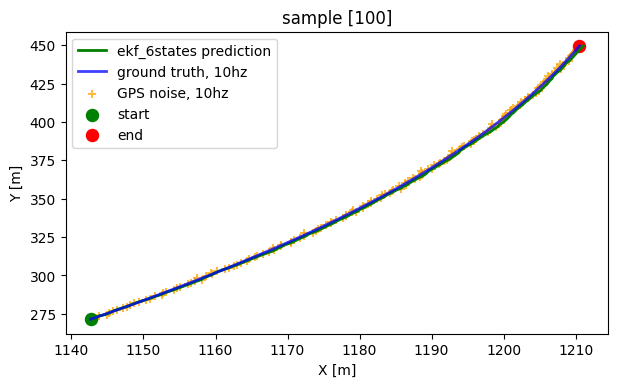

In [100]:
plot_traj_comp(
    x_est_sample[:, 0], x_est_sample[:, 1],
    sample_traj['x_noise'].values, sample_traj['y_noise'].values,
    sample_traj['x'].values, sample_traj['y'].values,
    sample_idx=sample_idx
)

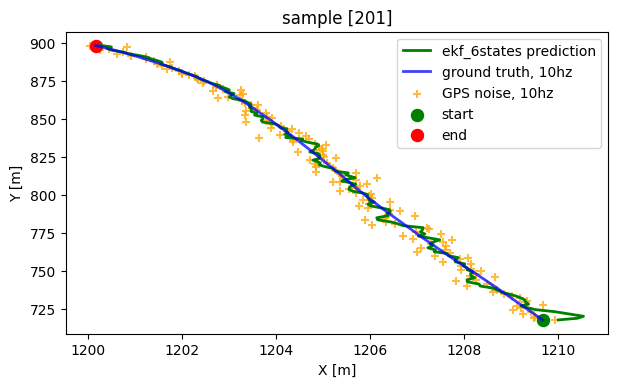

In [348]:
plot_traj_comp(
    x_est_sample[:, 0], x_est_sample[:, 1],
    sample_traj['x_noise'].values, sample_traj['y_noise'].values,
    sample_traj['x'].values, sample_traj['y'].values,
    sample_idx=sample_idx
)

Text(0.5, 0, 'Filter Step')

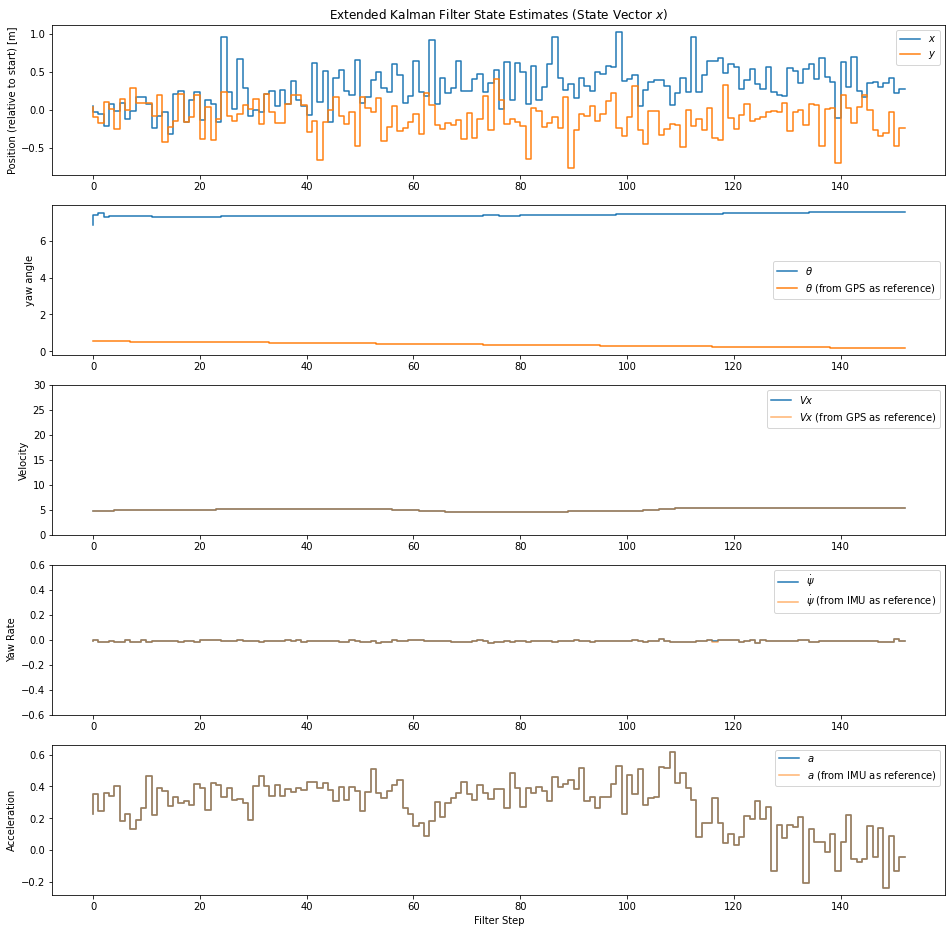

In [91]:
fig = plt.figure(figsize=(16, 16))
steps = range(x_est_sample.shape[0])

plt.subplot(511)
plt.step(steps, x_est_sample[:, 0]-sample_traj['x_noise'].values, label='$x$')
plt.step(steps, x_est_sample[:, 1]-sample_traj['y_noise'].values, label='$y$')
plt.title('Extended Kalman Filter State Estimates (State Vector $x$)')
plt.legend(loc='best')
plt.ylabel('Position (relative to start) [m]')

plt.subplot(512)
plt.step(steps, x_est_sample[:, 2], label=r'$\theta}$')
plt.step(steps, sample_traj['theta'].values / 180.0*np.pi , label=r'$\theta}$ (from GPS as reference)')
plt.ylabel('yaw angle')
plt.legend(loc='best')
           
plt.subplot(513)
plt.step(steps, x_est_sample[:, 3], label='$Vx$')
plt.step(steps, sample_traj['Vx'].values, label='$Vx$ (from GPS as reference)', alpha=0.6)
plt.ylabel('Velocity')
plt.ylim([0, 30])
plt.legend(loc='best')

plt.subplot(514)
plt.step(steps, x_est_sample[:, 4], label='$\dot \psi$')
plt.step(steps, sample_traj['omega_Zv'].values/180.0*np.pi, label='$\dot \psi$ (from IMU as reference)', alpha=0.6)
plt.ylabel('Yaw Rate')
plt.ylim([-0.6, 0.6])
plt.legend(loc='best')

plt.subplot(515)
plt.step(steps, x_est_sample[:, 5], label='$a$')
plt.step(steps, sample_traj['alpha_Xv'].values, label='$a$ (from IMU as reference)', alpha=0.6)
plt.ylabel('Acceleration')
#plt.ylim([-0.6, 0.6])
plt.legend(loc='best')
plt.xlabel('Filter Step')

# plt.savefig('Extended-Kalman-Filter-CTRA-State-Estimates.png', dpi=72, transparent=True, bbox_inches='tight')

### error metrics

In [92]:
# rmse
traj_est_sample = np.array([
    x_est_sample[:, 0], x_est_sample[:, 1]
])
traj_ground_truth = np.array([
    sample_traj['x'].values, sample_traj['y'].values
])

np.sqrt(mean_squared_error(traj_est_sample, traj_ground_truth))

In [349]:
# rmse
traj_est_sample = np.array([
    x_est_sample[:, 0], x_est_sample[:, 1]
])
traj_ground_truth = np.array([
    sample_traj['x'].values, sample_traj['y'].values
])

np.sqrt(mean_squared_error(traj_est_sample, traj_ground_truth))

In [193]:
pred_err = []
noise_err = []

x_gt = sample_traj['x'].values
y_gt = sample_traj['y'].values

for i in np.arange(x_est_sample.shape[0]):
    pred_coord = (x_est_sample[i][0], x_est_sample[i][1])
    gt_coord = (x_gt[i], y_gt[i])
    noise_coord = (x_noise[i], y_noise[i])
    
    pred_err.append(math.dist(pred_coord, gt_coord)) # meter
    noise_err.append(math.dist(noise_coord, gt_coord)) # meter

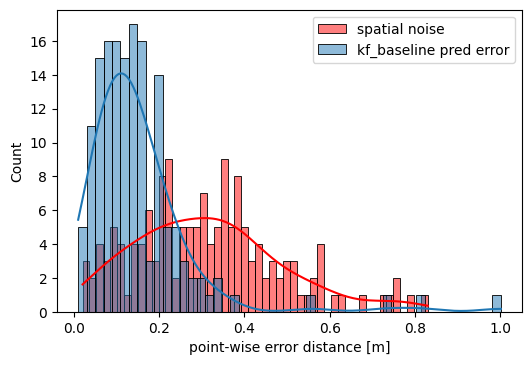

In [194]:
plt.figure(dpi=100)
ax = sns.histplot(
    noise_err,
    bins=50, label='spatial noise', color='red', kde=True)
sns.histplot(
    pred_err, 
    bins=50, label='kf_baseline pred error', kde=True)

plt.xlabel('point-wise error distance [m]')
plt.legend()
plt.show()

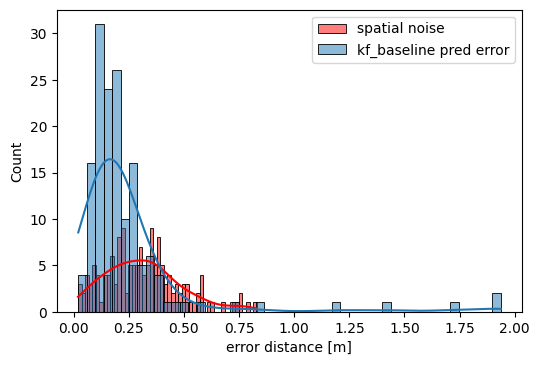

In [84]:
plt.figure(dpi=100)
ax = sns.histplot(
    noise_err,
    bins=50, label='spatial noise', color='red', kde=True)
sns.histplot(
    pred_err, 
    bins=50, label='kf_baseline pred error', kde=True)

plt.xlabel('error distance [m]')
plt.legend()
plt.show()

### sample batch estimation

In [142]:
def ekf_batch_eval(Q, batch_df):

    seg_pred_batch = []

    for df in batch_df:
        x_est_sample, x_noise, y_noise, x, y = ekf_6_stats(df, Q)
        x_est_df = pd.DataFrame({
            'x_est': x_est_sample[:, 0],
            'y_est': x_est_sample[:, 1],
            'theta': x_est_sample[:, 2],
            'Vx_est': x_est_sample[:, 3],
            'x_noise': x_noise,
            'y_noise': y_noise,
            'x': x,
            'y': y
            }
        )
        seg_pred_batch.append(x_est_df)
    
    return seg_pred_batch

In [210]:
# sample 50 as subsample for grid search
random.seed(0)
sample_trajs = random.sample(rl_seg_noise, 400)
len(sample_trajs)

In [211]:
def batch_rmse(space):
    
    Q = np.diag([
        space['q11'], space['q11'], space['q33'], space['q44'], space['q55'], space['q66']
    ])

    ekf_results = ekf_batch_eval(Q, batch_df=sample_trajs)
    rmse_lst = []

    for seg_df in ekf_results:
        traj_est = np.array([seg_df['x_est'].values, seg_df['y_est'].values])
        traj_gt = np.array([seg_df['x'].values, seg_df['y'].values])

        rmse_lst.append(np.sqrt(mean_squared_error(traj_est, traj_gt)))

    return np.average(rmse_lst)

In [212]:
from hyperopt import fmin, tpe, hp, anneal, Trials

space = {'q11': hp.uniform('q11', 0, 0.005),
       'q33' : hp.uniform('q33', 0, 0.2),
       'q44': hp.uniform('q44', 0, 0.3),
       'q55': hp.uniform('q55', 0, 0.1),
       'q66': hp.uniform('q66', 0, 0.2)
}

trials = Trials()

best = fmin(
    fn=batch_rmse, # function to optimize
    space=space, 
    algo=tpe.suggest, # optimization algorithm, hyperotp will select its parameters automatically
    max_evals=100, # maximum number of iterations
    trials=trials, # logging
    rstate=np.random.default_rng(12) # fixing random state for the reproducibility
)

  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

In [191]:
# original
seg_pred_batch = ekf_batch_eval(None, sample_trajs)

rmse_lst = []

for seg_df in seg_pred_batch:
    traj_est = np.array([seg_df['x_est'].values, seg_df['y_est'].values])
    traj_gt = np.array([seg_df['x'].values, seg_df['y'].values])

    rmse_lst.append(np.sqrt(mean_squared_error(traj_est, traj_gt)))

np.average(rmse_lst)

In [200]:
pred_err = []
noise_err = []

for j in np.arange(len(seg_pred_batch)):

    x_gt = seg_pred_batch[j]['x'].values
    y_gt = seg_pred_batch[j]['y'].values
    x_est = seg_pred_batch[j]['x_est'].values
    y_est = seg_pred_batch[j]['y_est'].values
    x_noise = seg_pred_batch[j]['x_noise'].values
    y_noise = seg_pred_batch[j]['y_noise'].values

    for i in np.arange(seg_pred_batch[0].shape[0]):
        pred_coord = (x_est[i], y_est[i])
        gt_coord = (x_gt[i], y_gt[i])
        noise_coord = (x_noise[i], y_noise[i])
        
        pred_err.append(math.dist(pred_coord, gt_coord)) # meter
        noise_err.append(math.dist(noise_coord, gt_coord)) # meter

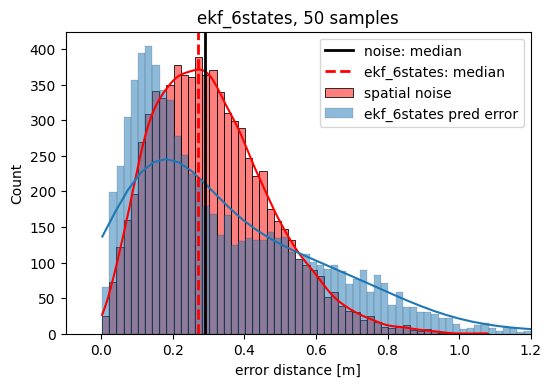

In [196]:
plt.figure(dpi=100)
ax = sns.histplot(
    noise_err,
    binwidth=0.02, label='spatial noise', color='red', kde=True)
sns.histplot(
    pred_err, 
    binwidth=0.02, label='ekf_6states pred error', kde=True)

ax.axvline(np.median(noise_err), color='k', lw=2, label='noise: median')
ax.axvline(np.nanmedian(np.array(pred_err)), color='red', ls='--', lw=2, label='ekf_6states: median')

plt.title('ekf_6states, 50 samples')
plt.xlabel('error distance [m]')
plt.xlim([-0.1, 1.2])
plt.legend()
plt.show()

Text(0.5, 0, 'ekf_6states, 50 samples, pred error')

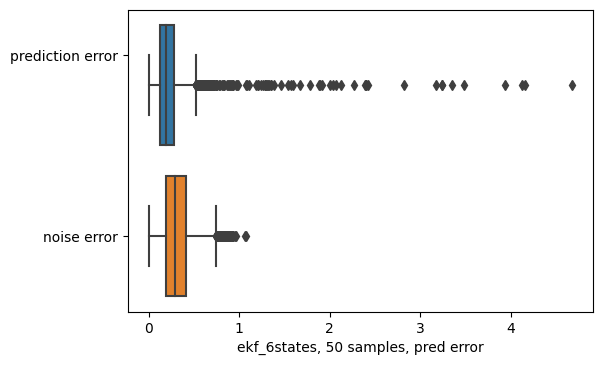

In [205]:
ax = sns.boxplot(data=[
    pred_err, noise_err
], orient='h')
ax.set_yticks([-0.2, 1], ['prediction error', 'noise error'])
plt.xlabel('ekf_6states, 50 samples, pred error')

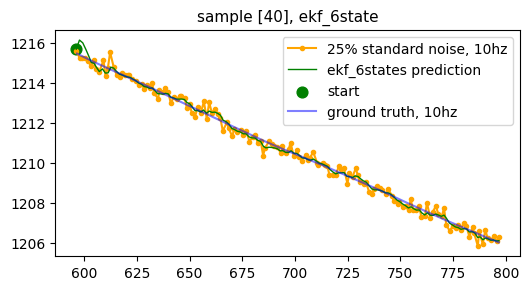

In [188]:
sample = 40
plt.figure(dpi=100, figsize=(6, 3))

plt.plot(seg_pred_batch[sample]['y_noise'], seg_pred_batch[sample]['x_noise'], '-o', label='25% standard noise, 10hz', ms=3, c='orange')
plt.plot(seg_pred_batch[sample]['y_est'], seg_pred_batch[sample]['x_est'], '-', linewidth=1, label='ekf_6states prediction', c='green')
plt.scatter(seg_pred_batch[sample]['y_est'][0], seg_pred_batch[sample]['x_est'][0], label='start', s=60, c='green')
plt.plot(seg_pred_batch[sample]['y'], seg_pred_batch[sample]['x'], label='ground truth, 10hz', c='blue', alpha=0.5)
plt.title(f'sample [{sample}], ekf_6state', fontsize=11)
plt.legend()
plt.show()

In [198]:
Q = np.diag([
    best['q11'], best['q11'], best['q33'], best['q44'], best['q55'], best['q66']
])

seg_pred_batch = ekf_batch_eval(Q, sample_trajs)

rmse_lst = []

for seg_df in seg_pred_batch:
    traj_est = np.array([seg_df['x_est'].values, seg_df['y_est'].values])
    traj_gt = np.array([seg_df['x'].values, seg_df['y'].values])

    rmse_lst.append(np.sqrt(mean_squared_error(traj_est, traj_gt)))

np.average(rmse_lst)

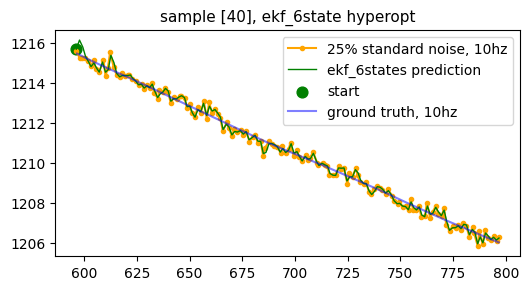

In [199]:
sample = 40
plt.figure(dpi=100, figsize=(6, 3))

plt.plot(seg_pred_batch[sample]['y_noise'], seg_pred_batch[sample]['x_noise'], '-o', label='25% standard noise, 10hz', ms=3, c='orange')
plt.plot(seg_pred_batch[sample]['y_est'], seg_pred_batch[sample]['x_est'], '-', linewidth=1, label='ekf_6states prediction', c='green')
plt.scatter(seg_pred_batch[sample]['y_est'][0], seg_pred_batch[sample]['x_est'][0], label='start', s=60, c='green')
plt.plot(seg_pred_batch[sample]['y'], seg_pred_batch[sample]['x'], label='ground truth, 10hz', c='blue', alpha=0.5)
plt.title(f'sample [{sample}], ekf_6state hyperopt', fontsize=11)
plt.legend()
plt.show()

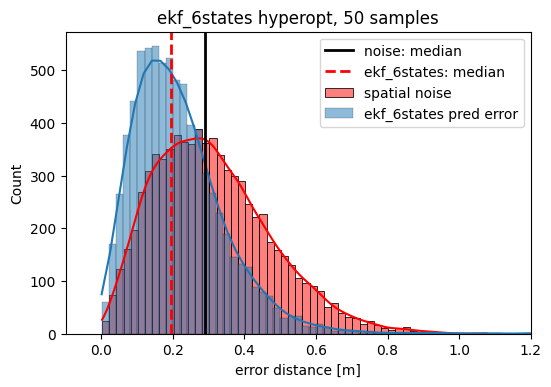

In [201]:
plt.figure(dpi=100)
ax = sns.histplot(
    noise_err,
    binwidth=0.02, label='spatial noise', color='red', kde=True)
sns.histplot(
    pred_err, 
    binwidth=0.02, label='ekf_6states pred error', kde=True)

ax.axvline(np.median(noise_err), color='k', lw=2, label='noise: median')
ax.axvline(np.nanmedian(np.array(pred_err)), color='red', ls='--', lw=2, label='ekf_6states: median')

plt.title('ekf_6states hyperopt, 50 samples')
plt.xlabel('error distance [m]')
plt.xlim([-0.1, 1.2])
plt.legend()
plt.show()

Text(0.5, 0, 'ekf_6states hyeropt, 50 samples, pred error')

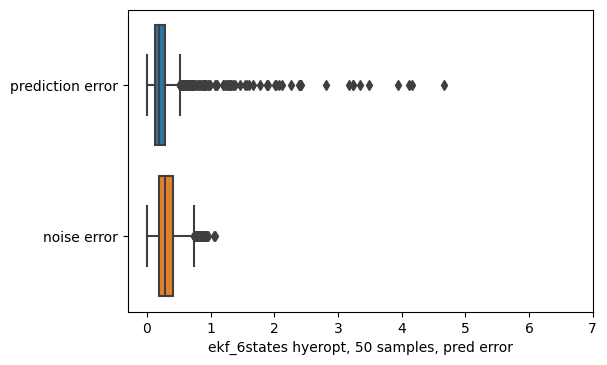

In [207]:
ax = sns.boxplot(data=[
    pred_err, noise_err
], orient='h')
ax.set_xlim([-0.3, 7])
ax.set_yticks([0, 1], ['prediction error', 'noise error'])
plt.xlabel('ekf_6states hyeropt, 50 samples, pred error')

### batch estimation

In [329]:
# runtime ~= 2min
# list of dataframe
rl_seg_pred = []

for df in rl_seg_noise:
    x_est_sample, x_noise, y_noise, x, y = ekf_6_stats(df)
    x_est_df = pd.DataFrame({
        'x_est': x_est_sample[:, 0],
        'y_est': x_est_sample[:, 1],
        'theta': x_est_sample[:, 2],
        'Vx_est': x_est_sample[:, 3],
        'x_noise': x_noise,
        'y_noise': y_noise,
        'x': x,
        'y': y
        }
    )
    rl_seg_pred.append(x_est_df)

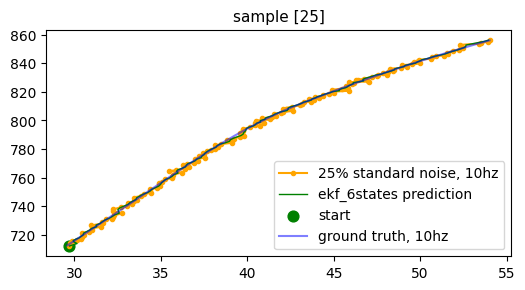

In [330]:
sample = 25
plt.figure(dpi=100, figsize=(6, 3))

plt.plot(rl_seg_pred[sample]['y_noise'], rl_seg_pred[sample]['x_noise'], '-o', label='25% standard noise, 10hz', ms=3, c='orange')
plt.plot(rl_seg_pred[sample]['y_est'], rl_seg_pred[sample]['x_est'], '-', linewidth=1, label='ekf_6states prediction', c='green')
plt.scatter(rl_seg_pred[sample]['y_est'][0], rl_seg_pred[sample]['x_est'][0], label='start', s=60, c='green')
plt.plot(rl_seg_pred[sample]['y'], rl_seg_pred[sample]['x'], label='ground truth, 10hz', c='blue', alpha=0.5)
plt.title(f'sample [{sample}]', fontsize=11)
plt.legend()
plt.show()

In [354]:
rl_seg_pred[476]

,x_est,y_est,theta,Vx_est,x_noise,y_noise,x,y
0,393.560619,955.534748,-2.029993,5.06,393.593073,955.600305,393.708653,955.421841
1,392.674038,954.847328,-2.367172,5.06,392.749462,955.089243,392.577997,954.859786
2,391.578556,954.144705,-2.486736,5.05,391.549917,954.212135,391.448991,954.297731
3,390.294882,953.708406,-2.631383,5.05,390.199869,953.887016,390.320810,953.734565
4,388.958476,953.388036,-2.730145,5.04,388.791340,953.569274,389.194279,953.170288
...,...,...,...,...,...,...,...,...
148,237.920016,865.790681,-2.564564,4.45,238.037118,865.612803,237.979997,865.695196
149,237.039160,865.155341,-2.558546,4.45,237.167792,865.129847,237.060605,865.075380
150,236.096143,864.541922,-2.560042,4.45,236.064407,864.534893,236.138737,864.456675
151,235.137300,863.852088,-2.554413,4.46,235.011036,863.665112,235.215218,863.837970


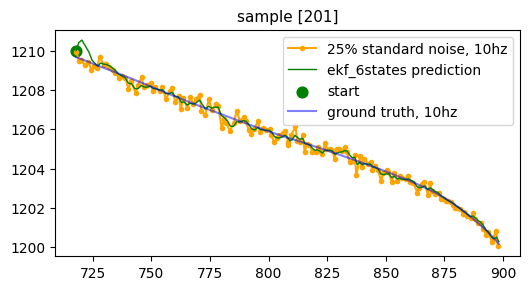

In [332]:
sample = 201
plt.figure(dpi=100, figsize=(6, 3))

plt.plot(rl_seg_pred[sample]['y_noise'], rl_seg_pred[sample]['x_noise'], '-o', label='25% standard noise, 10hz', ms=3, c='orange')
plt.plot(rl_seg_pred[sample]['y_est'], rl_seg_pred[sample]['x_est'], '-', linewidth=1, label='ekf_6states prediction', c='green')
plt.scatter(rl_seg_pred[sample]['y_est'][0], rl_seg_pred[sample]['x_est'][0], label='start', s=60, c='green')
plt.plot(rl_seg_pred[sample]['y'], rl_seg_pred[sample]['x'], label='ground truth, 10hz', c='blue', alpha=0.5)
plt.title(f'sample [{sample}]', fontsize=11)
plt.legend()
plt.show()

### more error metrics

In [199]:
def traj_distances_proj(df):

    length_m = 0
    length_m_pred = 0
    length_m_noise = 0

    for index, row in df.iterrows():
        try:
            # actual
            start = (row['y'], row['x'])
            end = (df.iloc[index+1]['y'], df.iloc[index+1]['x'])
            length_m += math.dist(start, end)

            # predicted
            start = (row['y_est'], row['x_est'])
            end = (df.iloc[index+1]['y_est'], df.iloc[index+1]['x_est'])
            length_m_pred += math.dist(start, end)

            # noise
            start = (row['y_noise'], row['x_noise'])
            end = (df.iloc[index+1]['y_noise'], df.iloc[index+1]['x_noise'])
            length_m_noise += math.dist(start, end)

        except:
            pass
    
    return length_m, length_m_pred, length_m_noise

In [333]:
pred_err = []
noise_err = []

for j in np.arange(len(rl_seg_pred)):

    x_gt = rl_seg_pred[j]['x'].values
    y_gt = rl_seg_pred[j]['y'].values
    x_est = rl_seg_pred[j]['x_est'].values
    y_est = rl_seg_pred[j]['y_est'].values
    x_noise = rl_seg_pred[j]['x_noise'].values
    y_noise = rl_seg_pred[j]['y_noise'].values

    for i in np.arange(rl_seg_pred[0].shape[0]):
        pred_coord = (x_est[i], y_est[i])
        gt_coord = (x_gt[i], y_gt[i])
        noise_coord = (x_noise[i], y_noise[i])
        
        pred_err.append(math.dist(pred_coord, gt_coord)) # meter
        noise_err.append(math.dist(noise_coord, gt_coord)) # meter

In [360]:
len(pred_err)

Text(0.5, 0, 'ekf_6states pred error')

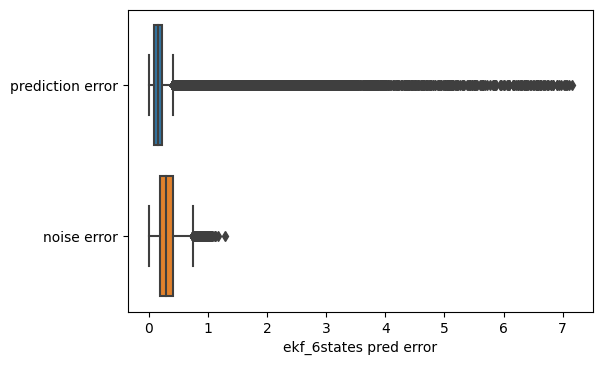

In [367]:
ax = sns.boxplot(data=[
    pred_err, noise_err
], orient='h')
ax.set_yticks([0, 1], ['prediction error', 'noise error'])
plt.xlabel('ekf_6states pred error')

Text(0.5, 0, 'ekf_6states pred error')

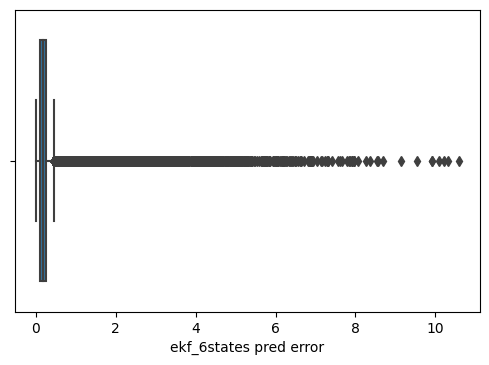

In [99]:
sns.boxplot(pred_err)
plt.xlabel('ekf_6states pred error')

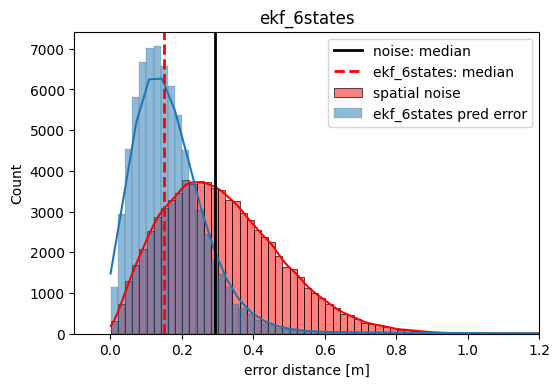

In [351]:
plt.figure(dpi=100)
ax = sns.histplot(
    noise_err,
    binwidth=0.02, label='spatial noise', color='red', kde=True)
sns.histplot(
    pred_err, 
    binwidth=0.02, label='ekf_6states pred error', kde=True)

ax.axvline(np.median(noise_err), color='k', lw=2, label='noise: median')
ax.axvline(np.nanmedian(np.array(pred_err)), color='red', ls='--', lw=2, label='ekf_6states: median')

plt.title('ekf_6states')
plt.xlabel('error distance [m]')
plt.xlim([-0.1, 1.2])
plt.legend()
plt.show()

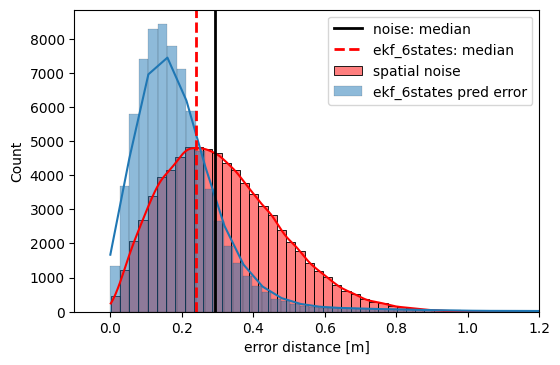

In [125]:
plt.figure(dpi=100)
ax = sns.histplot(
    noise_err,
    bins=50, label='spatial noise', color='red', kde=True)
sns.histplot(
    pred_err, 
    bins=400, label='ekf_6states pred error', kde=True)

ax.axvline(np.median(noise_err), color='k', lw=2, label='noise: median')
ax.axvline(np.nanmean(np.array(pred_err)), color='red', ls='--', lw=2, label='ekf_6states: median')

plt.xlabel('error distance [m]')
plt.xlim([-0.1, 1.2])
plt.legend()
plt.show()

In [341]:
# batch rmse
rmse_lst = []

for seg_df in rl_seg_pred:
    traj_est = np.array([seg_df['x_est'].values, seg_df['y_est'].values])
    traj_gt = np.array([seg_df['x'].values, seg_df['y'].values])

    rmse_lst.append(np.sqrt(mean_squared_error(traj_est_sample, traj_ground_truth)))

np.average(rmse_lst)

In [337]:
length_m_lst = []
length_m_pred_lst = []
length_m_noise_lst = []

for df in tqdm(rl_seg_pred):
    length_m, length_m_pred, length_m_noise = traj_distances_proj(df)
    length_m_lst.append(length_m)
    length_m_pred_lst.append(length_m_pred)
    length_m_noise_lst.append(length_m_noise)

100%|██████████| 500/500 [00:32<00:00, 15.19it/s]


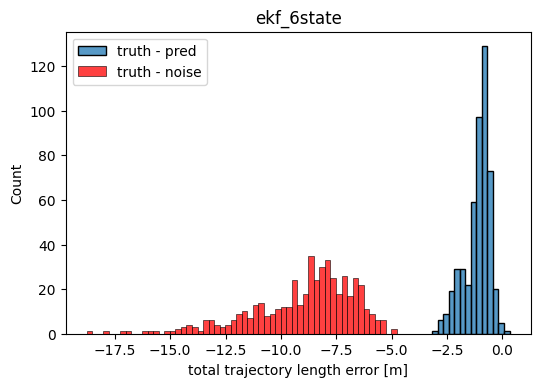

In [338]:
plt.figure(dpi=100)
sns.histplot(np.array(length_m_lst) - np.array(length_m_pred_lst), binwidth=0.25, label='truth - pred')
sns.histplot(np.array(length_m_lst) - np.array(length_m_noise_lst), binwidth=0.25, label='truth - noise', color='red')
plt.title('ekf_6state')
plt.xlabel('total trajectory length error [m]')
plt.legend()

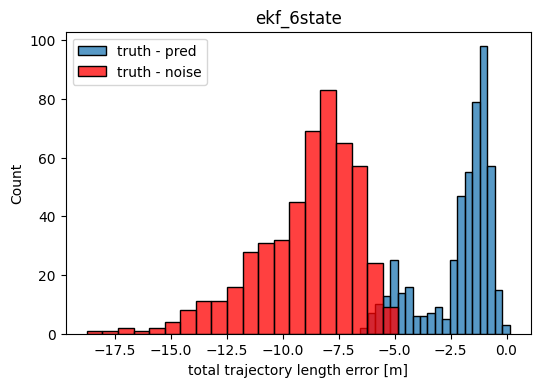

In [126]:
plt.figure(dpi=100)
sns.histplot(np.array(length_m_lst) - np.array(length_m_pred_lst), label='truth - pred')
sns.histplot(np.array(length_m_lst) - np.array(length_m_noise_lst), label='truth - noise', color='red')
plt.title('ekf_6state')
plt.xlabel('total trajectory length error [m]')
plt.legend()

## ekf_6states tuning

In [3]:
torch.tensor([
        [1,0,1,0],
        [0,1,0,1],
        [0,0,1,0],
        [0,0,0,1]
    ], dtype=torch.double)

tensor([[1., 0., 1., 0.],
        [0., 1., 0., 1.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]], dtype=torch.float64)